# Defining the APOGEE DR14 halo sample, fitting the density, and estimating the mass

In this notebook, we make the final definition of the statistical APOGEE DR14 halo sample. We then fit the density of the entire sample and MAPs at high and low $e$. Finally we make the plots showing the spatial structure of the MAPs, and the estimate of the stellar mass of the halo as a function of $\mathrm{[Fe/H]}$, $\mathrm{[Mg/Fe]}$ and $e$.


In [36]:
import os
import sys
#ensure that our APOGEE python will read DR14!
os.environ['RESULTS_VERS'] = 'l31c.2'
import numpy as np
import matplotlib.pyplot as plt
import utils
import densprofiles
import apogee.tools.read as apread
from galpy.util import bovy_coords
from galpy.orbit import Orbit, Orbits
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel, estimateDeltaStaeckel
from gaia_tools import xmatch
import mwdust
import tqdm
import gaia_tools.load as gload
import dill as pickle
import multiprocessing
import emcee
import scipy.optimize as op
from scipy import interpolate
from scipy.stats import gaussian_kde
from astroML.density_estimation import XDGMM
from sklearn.mixture import GaussianMixture
from isodist import FEH2Z, Z2FEH
import corner
import matplotlib
import safe_colours
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging')
params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# APOGEE DR14 and the selection function

first, we'll load up the APOGEE DR14 sample, using the distances from Leung & Bovy (2019b):

In [2]:
#load allStar (main sample w/ Leung & Bovy distances, removing duplicates)
allstar = apread.allStar(main=True, rmdups=True,use_astroNN_distances=True)
print(str(len(allstar))+' stars in total sample.')

/anaconda3/lib/python3.7/site-packages/apogee-1.-py3.7.egg/apogee/tools/read.py:1298: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")



100%|██████████| 43720/43720 [00:03<00:00, 14059.06it/s]


197175 stars in total sample.                                                   


Then we'll load in the selection function, statistical sample index, and effective selection functions. This pre-supposes that the

In [50]:
#load selection function/statIndx/effsel if they exist.

if os.path.exists('../sav/apogeeCombinedSF.dat'):
    with open('../sav/apogeeCombinedSF.dat', 'rb') as f:
        apo = pickle.load(f)
else:
    print('No pre-computed selection function found, please refer to selection-function.ipynb')
    
#load statIndx sample and pickle file
if os.path.exists('../sav/statIndx.dat'):
    with open('../sav/statIndx.dat', 'rb') as f:
        statIndx = pickle.load(f)
else:
    print('No pre-computed selection function found, please refer to selection-function.ipynb')
    
#re-define the distance modulus grid, and the Fe/H, Mg/Fe and eccentricity binning.
fehbins = np.array([-1.6,-1.4,-1.2,-1.,-0.8])
afebins = np.array([0.,0.2,0.4])
lowfehbins = np.array([-3.,-1.6])
lowafebins = np.array([0.,0.2,0.4])
ebins = [0.,0.7,1.]
ndistmods=301
minmax_distmods=[7.,19.]
nthreads = int(multiprocessing.cpu_count()//2)
isorec = utils.generate_lowfeh_isogrid()
dmap = mwdust.Combined15()
distmods = np.linspace(minmax_distmods[0], minmax_distmods[1], ndistmods)
ds = 10.**(distmods/5-2)
if os.path.exists('../essf/effsel_lowfehgrid_fehbins_inclArea.dat'):
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_lowfehgrid_fehbins_inclArea.dat', 'rb') as f:
        out = np.load(f)
else:
    print('No pre-computed effective selection function found, please refer to selection-function.ipynb')
    
#load the effective slection a single [Fe/H] selection across the whole range
if os.path.exists('../essf/effsel_grid_inclArea.dat'):
    sys.stdout.write('\r'+"loading saved effective selection function for APOGEE fields...\r")
    sys.stdout.flush()
    with open('../essf/effsel_grid_inclArea.dat', 'rb') as f:
        outarea = pickle.load(f)
else:
    print('No pre-computed effective selection function found, please refer to selection-function.ipynb')

100%|██████████| 30/30 [00:02<00:00, 12.19it/s]


# X-match with Gaia, and compute orbits

We need to X-match the APOGEE sample with Gaia DR2, and get all the information (i.e. including correlation between astrometric parameters). To do this we use the [`gaia_tools`](https://github.com/jobovy/gaia_tools) package, and its handy `xmatch.cds` function.

In [12]:
gaia2_matches, matches_indx = xmatch.cds(allstar[statIndx] ,colRA='RA',colDec='DEC',xcat='vizier:I/345/gaia2', gaia_all_columns=True)


/anaconda3/lib/python3.7/site-packages/astropy/io/votable/tree.py:711: W35: None:5:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/anaconda3/lib/python3.7/site-packages/astropy/io/votable/tree.py:711: W35: None:8:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/anaconda3/lib/python3.7/site-packages/astropy/io/votable/tree.py:711: W35: None:9:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/anaconda3/lib/python3.7/site-packages/astropy/io/votable/tree.py:711: W35: None:10:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/anaconda3/lib/python3.7/site-packages/astropy/io/votable/tree.py:711: W35: None:12:0: W35: 'value' attribute required for INFO elements
  warn_or_raise(W35, W35, ('value'), self._config, self._pos)

/an

Once that is done, lets go about estimating the orbital parameters. Instead of hiding this inside functions, the coordinate transformations etc are done step-by-step here:

In [20]:

ra, dec, parallax, pmra, pmdec, RV = gaia2_matches['ra'].data, gaia2_matches['dec'].data, allstar[statIndx][matches_indx]['weighted_dist']/1e3, gaia2_matches['pmra'].data, gaia2_matches['pmdec'].data, allstar[statIndx][matches_indx]['VHELIO_AVG']
radec, raparallax, rapmra, rapmdec = gaia2_matches['ra_dec_corr'].data, 0., gaia2_matches['ra_pmra_corr'].data, gaia2_matches['ra_pmdec_corr'].data
decparallax, decpmra, decpmdec = 0., gaia2_matches['dec_pmra_corr'].data, gaia2_matches['dec_pmdec_corr'].data
parallaxpmra, parallaxpmdec = 0., 0.
pmrapmdec = gaia2_matches['pmra_pmdec_corr'].data
ra_e, dec_e, parallax_e, pmra_e, pmdec_e, RV_e = gaia2_matches['ra_error'].data, gaia2_matches['dec_error'].data, allstar[statIndx][matches_indx]['weighted_dist_error']/1e3, gaia2_matches['pmra_error'].data, gaia2_matches['pmdec_error'].data, allstar[statIndx][matches_indx]['VERR']

cov = np.zeros([len(gaia2_matches),6,6])
cov[:,0] = np.dstack([ra_e**2, ra_e*dec_e*radec, ra_e*parallax_e*raparallax, ra_e*pmra_e*rapmra, ra_e*dec_e*rapmdec, np.zeros(len(gaia2_matches))])[0]
cov[:,1,1:] = np.dstack([dec_e**2, dec_e*parallax_e*decparallax, dec_e*pmra_e*decpmra, dec_e*pmdec_e*decpmdec, np.zeros(len(gaia2_matches))])[0]
cov[:,2,2:] = np.dstack([parallax_e**2, parallax_e*pmra_e*parallaxpmra, parallax_e*pmdec_e*parallaxpmdec, np.zeros(len(gaia2_matches))])[0]
cov[:,3,3:] = np.dstack([pmra_e**2, pmra_e*pmdec_e*pmrapmdec, np.zeros(len(gaia2_matches))])[0]
cov[:,4,4:] = np.dstack([pmdec_e**2, np.zeros(len(gaia2_matches))])[0]
cov[:,5,5] = RV_e**2
cov[:,:,0] = cov[:,0]
cov[:,1:,1] = cov[:,1,1:]
cov[:,2:,2] = cov[:,2,2:]
cov[:,3:,3] = cov[:,3,3:]
cov[:,4:,4] = cov[:,4,4:]

mean = np.dstack([ra,dec,parallax,pmra,pmdec,RV])[0]

omask = np.all(np.isfinite(mean), axis=1) & (np.all(np.isfinite(mean), axis=1)) & (allstar[statIndx][matches_indx]['FE_H'] < -0.5) & (allstar[statIndx][matches_indx]['FE_H'] > -3.) 

sampled_vxvv = np.empty((len(gaia2_matches[omask]),100,6))
for i in tqdm.tqdm_notebook(range(len(gaia2_matches[omask]))):
    try:
        sampled_vxvv[i] = np.random.multivariate_normal(mean[omask][i], cov[omask][i], 100)
    except ValueError:
        print(mean[o_mask][i])
        print(cov[o_mask][i])
sampled_vxvv = sampled_vxvv.reshape(len(gaia2_matches[omask])*100,6)

zo = 0.02
ro = 8.125
vo=220.
vxvv = np.copy(sampled_vxvv)
ra, dec= vxvv[:,0], vxvv[:,1]
dec[dec > 90.] = 90.
dec[dec < -90.] = -90.
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]

rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)
vsolar= np.array([-11.1,245.6,7.25]) #use SBD10 vR and vZ and SGR proper motion vT
vsun= np.array([0.,0.,0.,])+vsolar/vo
X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
XYZ = np.dstack([X, Y, Z])[0]
vxyz = np.dstack([vx,vy,vz])[0]

Rpz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0],XYZ[:,1],XYZ[:,2],Zsun=zo/ro)
vRvTvz = bovy_coords.vxvyvz_to_galcencyl(vxyz[:,0], vxyz[:,1], vxyz[:,2], Rpz[:,0], Rpz[:,1], Rpz[:,2],
                                                            vsun=vsun,
                                                            Xsun=1.,
                                                            Zsun=zo/ro,
                                                            galcen=True)

aAS = actionAngleStaeckel(pot = MWPotential2014, delta=0.4)
deltas = estimateDeltaStaeckel(MWPotential2014, Rpz[:,0], Rpz[:,2], no_median=True)

e,_,_,_ = aAS.EccZmaxRperiRap(Rpz[:,0],vRvTvz[:,0], vRvTvz[:,1], Rpz[:,2], vRvTvz[:,2], Rpz[:,1], delta=deltas)

mes = e.reshape(len(gaia2_matches[omask]),100)
print(np.shape(mes))
mes = np.median(mes,axis=1)

(10301, 100)


Before we move on, need to remove bulge fields, and determine which stars to remove from the sample (i.e. those which are not in fields where we have the selection function):

In [24]:
#taking mean of MC samples of covariance matrix
mrpz = Rpz.reshape(len(allstar[statIndx][matches_indx][omask]),100,3)
mrpz = np.mean(mrpz,axis=1)
# same for velocity
mvs = vRvTvz.reshape(len(allstar[statIndx][matches_indx][omask]),100,3)
mvs = np.mean(mvs,axis=1)

allstar_f = np.copy(allstar[statIndx][matches_indx])

#remove fields where effsel == 0 everywhere?
goodfields = ~np.all(out[0] < 1e-9, axis=1)
# remove fields in the bulge direction
glonglat = np.array([apo.glonGlat(apo._locations[i]) for i in range(len(apo._locations))]).reshape(len(apo._locations),2)
bulgeindx = ((glonglat[:,0] > 340) | (glonglat[:,0] < 20)) & (np.fabs(glonglat[:,1]) < 20)
goodindx = goodfields & ~bulgeindx & (apo._locations != 5093) #remove bad fields, bulge fields and one cluster field
goodlocs = apo._locations[goodindx]
# remove data not in the final field list
good_datamask = [allstar_f[omask]['LOCATION_ID'][i] in goodlocs for i in tqdm.tqdm_notebook(range(len(allstar[statIndx][matches_indx][omask])))]
good_datamask *= allstar_f[omask]['weighted_dist']/allstar_f[omask]['weighted_dist_error'] > 5.
# setup the grid in Rphiz where the effective selection function is evaluated
Rgrid, phigrid, zgrid = utils.Rphizgrid(apo, distmods)

# Checking out the final APOGEE DR14 halo sample

Now we have the final sample, lets determine where best to divide the eccentricity distribution and make a plot of this (Figure 1):

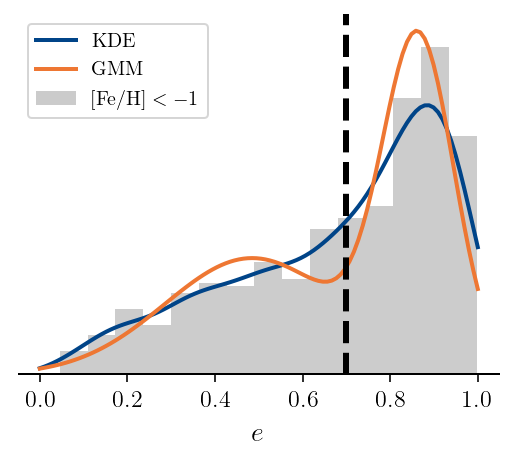

In [37]:

fig = plt.figure()
fig.set_size_inches(1.3*columnwidth,columnwidth)

eccsamp = e.reshape(len(allstar_f[omask]),100)
epercs = np.percentile(eccsamp,[16,50,84],axis=1)
kde = gaussian_kde(epercs[1][mask],)#bw_method=np.median(epercs[2][mask]-epercs[0][mask]))
xs = np.linspace(0.,1.,100)

plt.hist(epercs[1][mask], density=True, color='Black', alpha=0.2, bins=15, label=r'$\mathrm{[Fe/H]} < -1$')
plt.plot(xs, kde(xs), lw=2., color='#004488', label=r'KDE')
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(epercs[1][mask].reshape(-1,1))

# compute the AIC and the BIC
AIC = [m.aic(epercs[1][mask].reshape(-1,1)) for m in models]
BIC = [m.bic(epercs[1][mask].reshape(-1,1)) for m in models]

logprob = models[1].score_samples(xs.reshape(-1,1))
plt.plot(xs, np.exp(logprob), lw=2, color='#EE7733', label=r'GMM')

ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
xmin, xmax = ax.get_xaxis().get_view_interval()
ymin, ymax = ax.get_yaxis().get_view_interval()
ax.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))


plt.axvline(0.7, lw=3., linestyle='dashed', color='Black')

plt.xlabel(r'$e$')
plt.legend()

plt.savefig('../plots/eccentricity-dist_gmm.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/eccentricity-dist_gmm.png', format='png', dpi=400, bbox_inches='tight')

Plot the $\mathrm{[Fe/H]}$-$\mathrm{[Mg/Fe]}$ plane of the sample (Figure 2):

Text(3.5981652056740323, 0.5, '$\\mathrm{[Mg/Fe]}$')

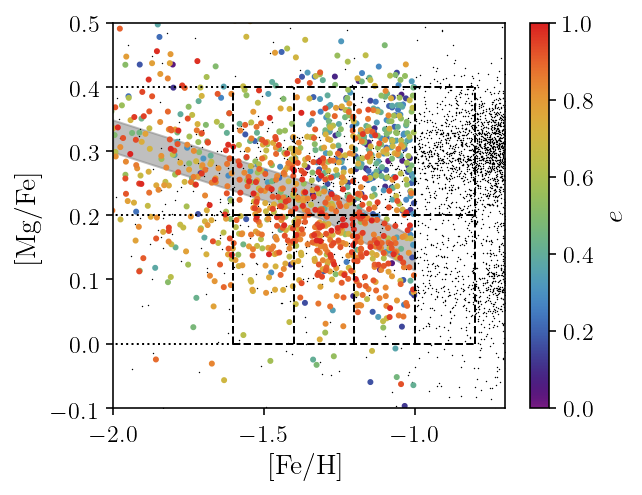

In [29]:
fig = plt.figure()
fig.set_size_inches(1.3*columnwidth, columnwidth)
mask = allstar[statIndx]['FE_H'] < -1.
plt.scatter(allstar_f['FE_H'], allstar_f['MG_FE'], s=0.5, color='Black', lw=0., rasterized=True)
            
            

mask = (allstar_f[omask]['FE_H'] < -1.) & good_datamask
esort = np.argsort(mes[mask])
plt.scatter(allstar_f[omask]['FE_H'][mask][esort],allstar_f[omask]['MG_FE'][mask][esort], s=4, c=mes[mask][esort], label=r'low $\mathrm{[Fe/H]}$', cmap=cm_rainbow, vmin=0.,vmax=1.)
plt.xlim(-2.,-0.7)
plt.ylim(-0.1,0.5)

ylim = plt.ylim()
yscale = (ylim[1]-ylim[0])

xlim = plt.xlim()
xscale = (xlim[1]-xlim[0])
for tbin in fehbins:
    plt.axvline(tbin, ymin=(0-ylim[0])/yscale, ymax=(0.4-ylim[0])/yscale, linestyle='dashed', color='Black')

for tbin in afebins:
    plt.axhline(tbin, xmin=(fehbins[0]-xlim[0])/xscale, xmax=(fehbins[-1]-xlim[0])/xscale, linestyle='dashed', color='Black')

lowbins = [-3,-1.6]
lowafebins = [0.,0.2,0.4]

for tbin in lowfehbins:
    plt.axvline(tbin, ymin=(0-ylim[0])/yscale, ymax=(0.4-ylim[0])/yscale, linestyle='dotted', color='Black')
    
for tbin in lowafebins:
    plt.axhline(tbin, xmin=(lowfehbins[0]-xlim[0])/xscale, xmax=(lowfehbins[-1]-xlim[0])/xscale, linestyle='dotted', color='Black')

    
m1, m2, br, br_level = [-0.15, -0.26, -1.31,0.22]
def sausage(feh, par=[m1,m2, br, br_level]):
    m1,m2,br,br_level = par
    if isinstance(feh,float):
        feh = np.array([feh,])
    out = np.zeros(len(feh))
    c = br_level-m1*br
    c2 = br_level-m2*br
    out[feh < br] = m1*feh[feh < br] + c
    out[feh > br] = m2*feh[feh >br] + c2
    return out
#plt.colorbar(label=r'$\log_{10}(M_*)\ \mathrm{[M_\odot]}$')
xs = np.linspace(-2.,-1.,100)
plt.fill_between(xs, sausage(xs)+0.025, sausage(xs)-0.025, zorder=-1, color='Grey', alpha=0.5)
#plt.legend(loc=1)

plt.colorbar(label=r'$e$')
fig.tight_layout()
plt.xlabel(r'$\mathrm{[Fe/H]}$')
plt.ylabel(r'$\mathrm{[Mg/Fe]}$')

plt.savefig('../plots/MAPs_bins_e.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/MAPs_bins_e.png', format='pdf', dpi=400, bbox_inches='tight')

Take a look at the spatial distribution of the sample (Figure 3):

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "



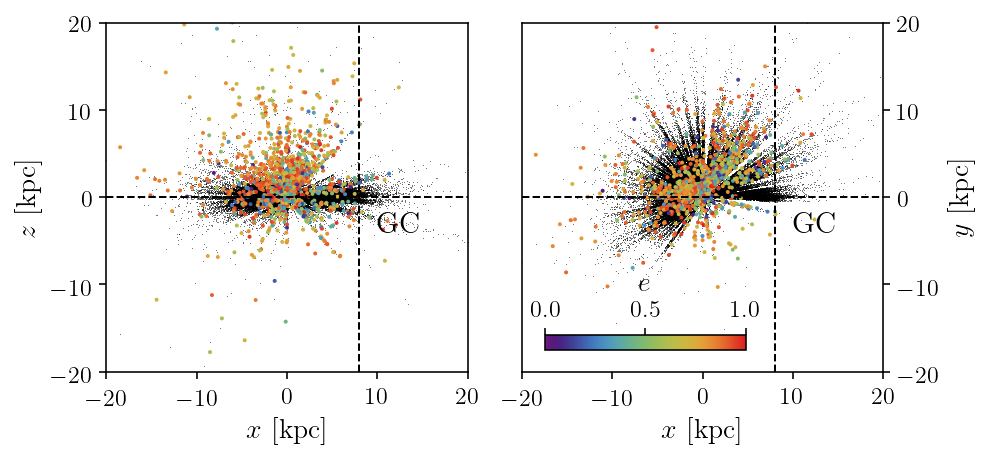

In [33]:
#Calculate the XYZ and Rphiz coordinates of the two samples and the rest of APOGEE DR14.
def allstar_to_coords(dat):
    l, b, d = dat['GLON'], dat['GLAT'], dat['weighted_dist']/1e3
    XYZ = bovy_coords.lbd_to_XYZ(l,b,d, degree=True)
    Rphiz = bovy_coords.XYZ_to_galcencyl(XYZ[:,0], XYZ[:,1], XYZ[:,2], Xsun=8., Zsun=0.02)
    return XYZ, Rphiz
    

XYZ, Rphiz = allstar_to_coords(allstar[statIndx][matches_indx])
oXYZ, oRphiz = allstar_to_coords(allstar[statIndx][matches_indx][omask])

#Plot the spatial distribution of the stars in x-y and x-z
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth,columnwidth)
mask = (allstar_f[omask]['FE_H'] < -1.) & good_datamask
ax[0].scatter(XYZ[:,0],XYZ[:,2], c='Black', s=0.1, lw=0., zorder=-1, rasterized=True)
ax[0].scatter(oXYZ[:,0][mask],oXYZ[:,2][mask], c=mes[mask], s=1., cmap=cm_rainbow, vmin=0., vmax=1.)
ax[0].axvline(8., c='Black', linestyle='dashed')
ax[0].axhline(0., c='Black', linestyle='dashed')
ax[0].set_ylim(-20,20)
ax[0].set_xlim(-20,20)
ax[1].scatter(XYZ[:,0],XYZ[:,1], c='Black', s=0.1, lw=0., zorder=-1, rasterized=True)
s = ax[1].scatter(oXYZ[:,0][mask], oXYZ[:,1][mask], c=mes[mask], s=1., cmap=cm_rainbow, vmin=0., vmax=1.)

ax[1].axvline(8., c='Black', linestyle='dashed')
ax[1].axhline(0., c='Black', linestyle='dashed')
ax[1].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[0].set_xlabel(r'$x\ \mathrm{[kpc]}$')
ax[1].set_xlabel(r'$x\ \mathrm{[kpc]}$')
ax[0].set_ylabel(r'$z\ \mathrm{[kpc]}$')
ax[1].set_ylabel(r'$y\ \mathrm{[kpc]}$')
ax[0].text(10,-4,r'GC', fontsize=15)
ax[1].text(10,-4,r'GC', fontsize=15)

cax=fig.add_axes([0.55,0.25,0.2,0.03])

plt.colorbar(s, cax=cax, orientation='horizontal', label=r'$e$')
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')

fig.tight_layout()
plt.savefig('../plots/MAPs_spatial_e.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/MAPs_spatial_e.png', format='pdf', dpi=400, bbox_inches='tight')

In [34]:
#these functions are necessary to do the fits to the APOGEE giants. They could be in with the utils, but for simplicity, I just put them here!

#first need to get the minimum J-K in each field
jkmins = np.array([apo.JKmin(apo._locations[i]) for i in range(len(apo._locations))])

def fit_bin_mask(mask, fehrange=[-1.6,-1.], effsel=out[0], model=densprofiles.triaxial_single_angle_qvar, just_MLE=True, just_MCMC=False, mass=False, init= [2.,0.5,0.5,0.8,1/10.,0.5,0.5,0.5], ncut=40, analytic=False, inttype='spherical'):
    '''
    Fits the stars defined by a mask to the APOGEE low metallicity sample
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    fehrange - the range in Fe/H spanned by the sample defined by mask
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    just_MLE - do the Maximum Likelihood and return opt
    just_MCMC - do the MCMC
    mass - also compute the total mass
    init - initial input parameters for the density model
    ncut - number of samples to cut from each MCMC chain
    analytic - compute the mass integral analytically (only works for spherical density models)
    inttype - the coordinate scheme for the integration grid for mass computation
    OUTPUT:
    opt - opt from op.minimize
    samples - MCMC samples
    masses - MC samples of mass
    facs - the normalisation factor corresponding to each mass sample
    '''
    #needs goodindx defined above. 'mask' must be same length as gaia2_matches[omask].
    print(sum(mask))
    if not just_MCMC:
        # do MLE. 
        opt = op.fmin(lambda x: utils.mloglike(x,model, effsel[goodindx]*ds**3.*np.log(10)/5.*(distmods[1]-distmods[0]), Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx], mrpz[:,0][mask]*8., mrpz[:,1][mask], mrpz[:,2][mask]*8.), init, full_output=True)
        print(opt[0])
        if just_MLE:
            return opt
    # do MCMC initialised from best result from MLE or from init params given
    ndim, nwalkers = len(init), 200
    if just_MCMC:
        pos = [init + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    else:
        pos = [opt[0] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
    nit = 200
    threads = 4
    #only effsel for good fields
    effsel_in = effsel[goodindx]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
    #re-build Rphiz grid
    Rgrid_in, phigrid_in, zgrid_in = Rgrid[goodindx], phigrid[goodindx], zgrid[goodindx]
    #set up sampler and do the sampling.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, utils.loglike, 
                                        args=(model, effsel_in, Rgrid_in, phigrid_in, zgrid_in, mrpz[:,0][mask]*8., mrpz[:,1][mask], mrpz[:,2][mask]*8.), 
                                        threads=threads)
    for i, result in tqdm.tqdm_notebook(enumerate(sampler.sample(pos, iterations=nit)), total=nit):
        continue
    #cut ncut samples from each chain
    samples = sampler.chain[:, ncut:, :].reshape((-1, ndim))
    if not mass:
        if just_MCMC:
            return samples
        else:
            return opt, samples
    isofactors = np.zeros(len(effsel[goodindx]))
    for i in range(len(isofactors)):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx][i]) & (isorec['logg'] < 3) & (isorec['logg'] > 1) & (isorec['logAge'] > 10)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx][i])
        isofactors[i] = avmass/massratio
    print(np.unique(isofactors))
    #set up grid for integration
    if inttype == 'spherical':
        rthetaphigrid = np.mgrid[2.:70:150j,0:np.pi:150j,0:2*np.pi:150j]
        dr = (70-2.)/149
        dtheta = (np.pi-0.)/149
        dphi = (2*np.pi-0.)/149
        shape = np.shape(rthetaphigrid.T)
        rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
        deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
        x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
        y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
        z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
        xyzgrid = np.dstack([x,y,z])[0]
        rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if inttype == 'cartesian':
        xyzgrid = np.mgrid[-50.:50.:150j,-50.:50.:150j,-50.:50.:150j]
        delta = xyzgrid[0,:,0,0][1]-xyzgrid[0,:,0,0][0]
        deltafactor = delta**3
        shape = np.shape(xyzgrid.T)
        xyzgrid = xyzgrid.T.reshape(np.product(shape[:3]),shape[3])
        rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
        rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk or model is densprofiles.triaxial_broken_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
        masses = np.zeros((400,3))
    else:
        masses = np.zeros(400)
    facs = np.zeros(400)
    for ii,params in tqdm.tqdm_notebook(enumerate(samples[np.random.choice(len(samples), 400, replace=False)]), total=400):
        rate = model(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params)*effsel[goodindx]*ds**3*np.log(10)/5.*(distmods[1]-distmods[0])
        sumrate = np.sum(rate.T/isofactors)
        norm = sum(mask)/sumrate
        fac = norm*(180./np.pi)**2
        if analytic:
            #only for spherical power law!
            rsun = np.sqrt(8.**2+0.02**2)
            min_r = 2.
            max_r = 70.
            alpha = params[0]
            integral = 4*np.pi*((rsun**alpha*max_r**(3-alpha))/(3-alpha)-(rsun**alpha*min_r**(3-alpha))/(3-alpha))
            masses[ii] = integral*fac
        else:
            if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk or model is densprofiles.triaxial_broken_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk:
                denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
                halodens = denstxyz[0]*fac
                diskdens = denstxyz[1]*fac
                fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
                masses[ii] = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)
            else:
                denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
                masses[ii] =  np.sum(denstxyz*deltafactor)
        #densfunc = lambda r,phi,z: r*model(r,phi,z,params=params)
        #integral = nquad(densfunc, [[3.,50.],[0.,2*np.pi],[-30.,30.]])
        #masses[ii] = integral[0]*fac
        facs[ii] = fac
    if just_MCMC:
        return samples, masses, facs
    return opt, samples, masses, facs

def normalisation_from_fixed_profile(mask, effsel, model, params, fehrange=[-3.,-1.], fixnorm=None):
    '''
    computes the normalisation or mass from the APOGEE star counts for a fixed profile
    IN:
    mask - must be same length as gaia2_matches[omask], and must have Fe/H limits that go into fehrange.
    effsel - the effective selection function corresponding to the sample in mask
    model - the density model to be fit
    params - parameters of the input density model (fixed)
    fehrange - the range in Fe/H spanned by the sample defined by mask
    fixnorm - fix normalisation to one (supplied) value (instead of using APOGEE star counts)
    OUTPUT:
    fac - the normalisation factor (returns fixnorm if set)
    mass - the mass for the input parameters 
    norm - normalisation factor
    '''
    isofactors = np.zeros(len(effsel[goodindx]))
    for i in range(len(isofactors)):   
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['Jmag']-isorec['Ksmag'] > jkmins[goodindx][i]) & (isorec['logg'] < 3) & (isorec['logg'] > 1) & (isorec['logAge'] > 10)
        avmass = utils.average_mass(isorec[isomask], lowfehgrid=True)
        isomask = (Z2FEH(isorec['Zini']) > fehrange[0]) & (Z2FEH(isorec['Zini']) < fehrange[1]) & (isorec['logAge'] > 10)  #& (isorec['J']-isorec['K'] > 0.3) & (isorec['logg'] < 3) & (isorec['logg'] > 1)
        massratio = utils.mass_ratio(isorec[isomask], lowfehgrid=True, minjk=jkmins[goodindx][i])
        isofactors[i] = avmass/massratio
    rthetaphigrid = np.mgrid[2.:70.:200j,0:np.pi:150j,0:2*np.pi:150j]
    dr = (70.-2.)/199
    dtheta = (np.pi-0.)/149
    dphi = (2*np.pi-0.)/149
    shape = np.shape(rthetaphigrid.T)
    rthetaphigrid = rthetaphigrid.T.reshape(np.product(shape[:3]),shape[3])
    deltafactor = rthetaphigrid[:,0]**2*np.sin(rthetaphigrid[:,1])*dr*dtheta*dphi
    x = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.cos(rthetaphigrid[:,2])
    y = rthetaphigrid[:,0]*np.sin(rthetaphigrid[:,1])*np.sin(rthetaphigrid[:,2])
    z = rthetaphigrid[:,0]*np.cos(rthetaphigrid[:,1])
    xyzgrid = np.dstack([x,y,z])[0]
    rphizgrid = bovy_coords.rect_to_cyl(xyzgrid[:,0], xyzgrid[:,1], xyzgrid[:,2])
    rphizgrid = np.dstack([rphizgrid[0],rphizgrid[1],rphizgrid[2]])[0]
    rate = model(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params)*effsel[goodindx]*ds**3*(distmods[1]-distmods[0])
    sumrate = np.sum(rate.T/isofactors)
    norm = sum(mask)/sumrate
    fac = norm*(180./np.pi)**2
    if fixnorm is not None:
        fac = fixnorm*(1e3)**3
    if model is densprofiles.triaxial_single_angle_zvecpa_plusexpdisk or model is densprofiles.triaxial_einasto_zvecpa_plusexpdisk:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params, split=True)
        halodens = denstxyz[0]*fac
        diskdens = denstxyz[1]*fac
        fulldens = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass = np.sum(halodens*deltafactor), np.sum(diskdens*deltafactor), np.sum(fulldens*deltafactor)
    else:
        denstxyz = model(rphizgrid[:,0],rphizgrid[:,1],rphizgrid[:,2], params=params)*fac
        mass =  np.sum(denstxyz*deltafactor)
    return fac, mass, norm

# Fitting the entire $-3 < \mathrm{[Fe/H]} < -1$ sample

First, we fit the triaxial single power law with exponential cut-off to the entire sample of stars between $-3 < \mathrm{[Fe/H]} < -1$. We also fit a simple spherical power law to demonstrate the better quality of the fit afforded by the more complex profile.

First up, lets make a mask for this sample, and look at its extent in $R$ and $z$: 

number of stars in full Fe/H range: 838


Text(0, 0.5, '$z\\ \\mathrm{[kpc]}$')

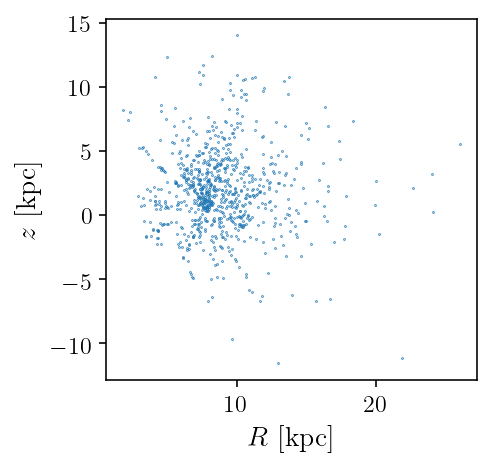

In [61]:
mask= (allstar_f[omask]['FE_H'] > -3.) & (allstar_f[omask]['FE_H'] < -1.) & \
                  (allstar_f[omask]['MG_FE'] > 0.) & (allstar_f[omask]['MG_FE'] < 0.4) & \
                    (allstar_f[omask]['LOGG'] > 1.) & (allstar_f[omask]['LOGG'] < 3.) & \
                  (mes > 0.) & (mes < 1.) &\
                  good_datamask
print('number of stars in full Fe/H range: '+str(sum(mask))+'')
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
plt.scatter(mrpz[:,0][mask]*8., mrpz[:,2][mask]*8., s=0.1)
plt.xlabel(r'$R\ \mathrm{[kpc]}$')
plt.ylabel(r'$z\ \mathrm{[kpc]}$')

Now, lets fit this sample for the two models using `fit_bin_mask` as defined above:

In [41]:
opt, samples, masses, facs = fit_bin_mask(mask, fehrange=[-3.,-1.], effsel=outarea, model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.5,0.01,0.9,0.9,0.,0.99,0.,0.01], ncut=100, analytic=False)

838
Optimization terminated successfully.
         Current function value: 9134.890882
         Iterations: 660
         Function evaluations: 1019
[3.88158202e+00 1.17750903e-02 7.48226590e-01 5.37817577e-01
 3.44740006e-04 9.99675208e-01 1.29489877e-04 5.22516288e-03]


[273.38548535 537.58924393]


In [42]:
sopt, ssamples, smasses, sfacs = fit_bin_mask(mask, fehrange=[-3.,-1.0], effsel=outarea, model=densprofiles.spherical, just_MLE=False, just_MCMC=False, mass=True, init= [2.5], ncut=100, analytic=True)

838
Optimization terminated successfully.
         Current function value: 9267.896536
         Iterations: 17
         Function evaluations: 34
[3.93493652]


[273.38548535 537.58924393]


Take a look what the total mass estimated is:

In [64]:
totms = np.nanpercentile(masses, [16,50,84])/1e8
print('total mass estimated from this profile is '+str(round(totms[1])+'e8 M_sun')

total mass estimated from this profile is 5.576019956725325e8 M_sun


Make the diagnostics of the MCMC (paper Figure 4):

838


838


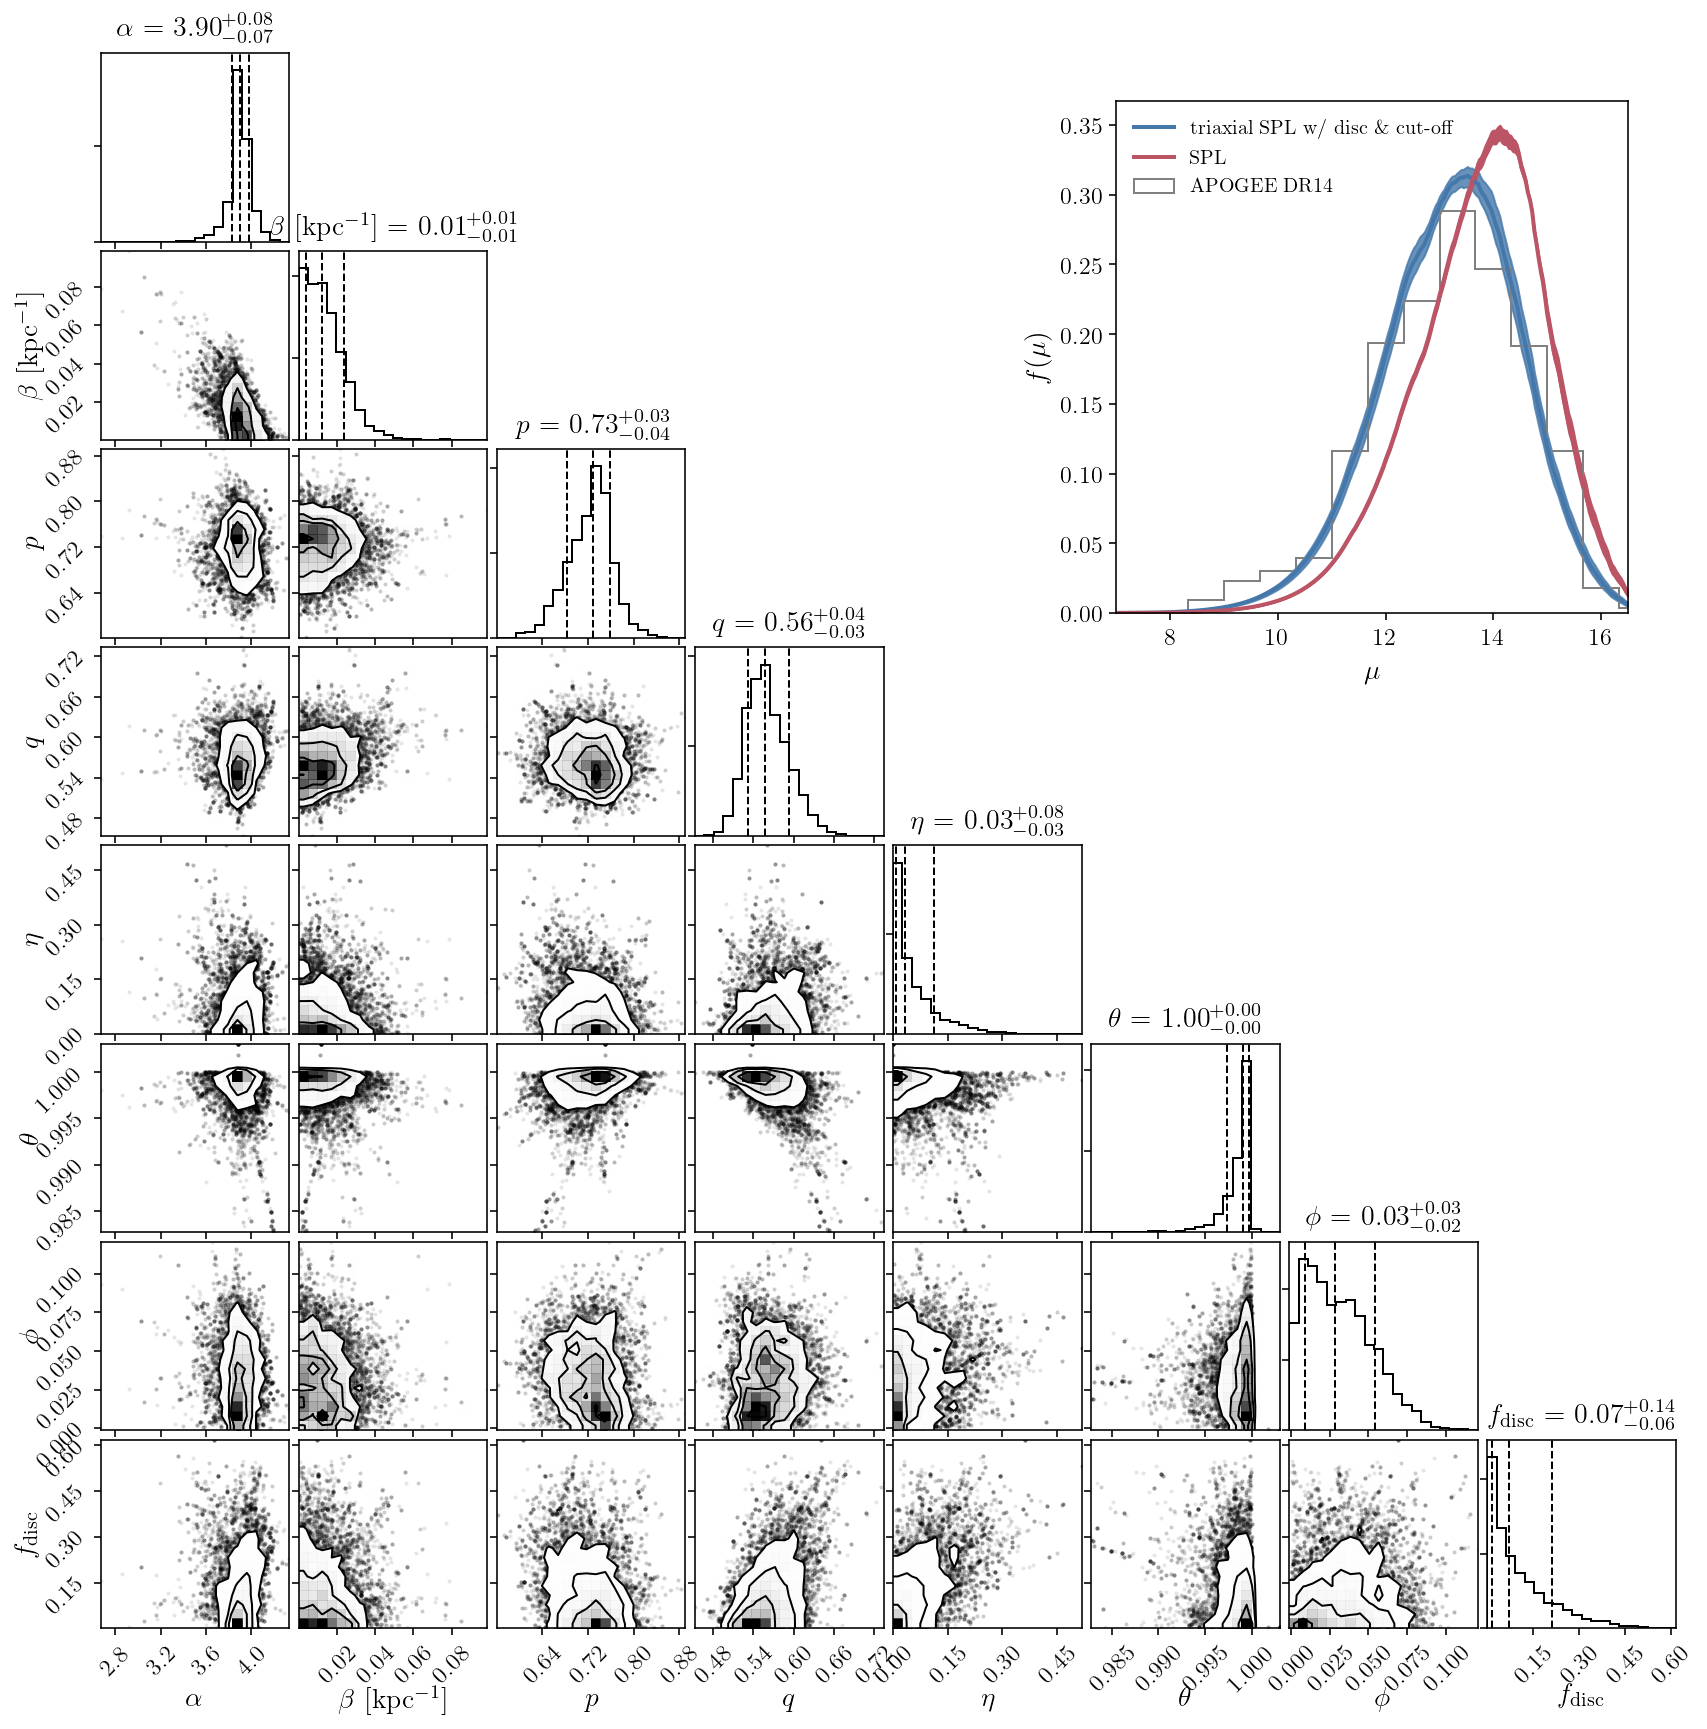

In [49]:
def pdistmod_model(densfunc, params, effsel, returnrate=False):
    rate = (densfunc(Rgrid[goodindx],phigrid[goodindx],zgrid[goodindx],params=params))*effsel[goodindx]*ds**3
    pdt = np.sum(rate,axis=0)
    pd = pdt/np.sum(pdt)/(distmods[1]-distmods[0])
    if returnrate:
        return pd, pdt, rate
    return pd, pdt

def check_fit(mask, samp, effsel, model, distmods, sample=False):
    print(sum(mask))
    pds = np.empty((200,len(distmods)))
    if sample:
        for ii,params in tqdm.tqdm_notebook(enumerate(samp[np.random.randint(len(samp), size=200)]), total=200):
            pd, pdt,rate = pdistmod_model(model, params, effsel, returnrate=True)
            pds[ii] = pd
        return pds
    else:
        pd, pdt, rate = pdistmod_model(model, np.median(samp,axis=0), effsel, returnrate=True)
        return pd

pd = check_fit(mask, samples, outarea, densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, distmods,sample=True)
spd = check_fit(mask, ssamples, outarea, densprofiles.spherical, distmods, sample=True)

labels = [r'$\alpha$',r'$\beta\ \mathrm{[kpc^{-1}]}$', r'$p$', r'$q$', r'$\eta$', r'$\theta$', r'$\phi$', r'$f_\mathrm{disc}$']
fig = corner.corner(samples, show_titles=True, quantiles=[0.16,0.5,0.84], labels=labels)

ax = fig.add_axes([0.65,0.65,0.3,0.3])

data_distmod= 5*np.log10(allstar_f[omask]['weighted_dist'][mask])-5
ax.hist(data_distmod, density=True, range=[distmods[0],distmods[-1]], bins=18, color='gray', histtype='step', label='APOGEE DR14')
ax.plot(distmods,np.nanpercentile(pd,50,axis=0),lw=2., color='#4477AA', label=r'triaxial SPL w/ disc \& cut-off')
ax.fill_between(distmods,np.nanpercentile(pd,5,axis=0),np.nanpercentile(pd,95,axis=0), color='#4477AA', alpha=0.8)
ax.plot(distmods,np.nanpercentile(spd,50,axis=0), lw=2., color='#BB5566', label='SPL')
ax.fill_between(distmods,np.nanpercentile(spd,5,axis=0),np.nanpercentile(spd,95,axis=0), color='#BB5566')
ax.set_xlim(7,16.5)
ax.legend(frameon=False, loc=2)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$f(\mu)$')

fig.set_size_inches(1.7*textwidth,1.7*textwidth)

#plt.savefig('../plots/fullsample_corner.pdf', format='pdf', dpi=400, bbox_inches='tight')
#plt.savefig('../plots/fullsample_corner.png', format='png', dpi=400, bbox_inches='tight')

# Fitting MAPs

Now lets fit the MAPs at low and high eccentricity. The edges of the MAPs and the eccentricity split is hard coded in here, but can be adjusted (but would need to re-calculate your effective selection function etc. in this case!). You can change the eccentricity split without re-calculating the effective selection function (this was done for the paper, to check the systematics on the mass under adjustment of this cut).

This is a pretty 'hacky' way of doing things, but gets the job done in time. We just run through each bin, perform fit and then store the samples and optimum parameters.

In [51]:
afebins = [0.,0.2,0.4]
ebins = [0.,0.7,1.]
fehbins = [-1.6,-1.4,-1.2,-1.]
lowafebins = [0.,0.4]
lowebins = [0.,0.7,1.]
lowfehbins = [-3,-1.6]

if os.path.exists('../sav/MAPs_spl_cutoff+disk_eccentricity0p7.npy'):
    with open('../sav/MAPs_spl_cutoff+disk_eccentricity0p7.npy', 'rb') as f:
        esamples = np.load(f)
        emasses = np.load(f)
        enbins = np.load(f)
        efacs = np.load(f)
        lowesamples = np.load(f)
        lowemasses = np.load(f)
        lowenbins = np.load(f)
        lowefacs = np.load(f)
else:
    esamples = np.zeros((len(fehbins)-1,len(afebins)-1,len(ebins)-1,20000,8))
    emasses = np.zeros((len(fehbins)-1,len(afebins)-1,len(ebins)-1,400,3))
    enbins = np.zeros((len(fehbins)-1,len(afebins)-1,len(ebins)-1))
    efacs = np.zeros((len(fehbins)-1,len(afebins)-1,len(ebins)-1,400))
    for i in range(len(fehbins)-1):
        for j in range(len(afebins)-1):
            for k in range(len(ebins)-1):
                print(fehbins[i],afebins[j],ebins[k])
                mask= (allstar_f[omask]['FE_H'] > fehbins[i]) & (allstar_f[omask]['FE_H'] < fehbins[i+1]) & \
                                  (allstar_f[omask]['MG_FE'] > afebins[j]) & (allstar_f[omask]['MG_FE'] < afebins[j+1]) & \
                                    (allstar_f[omask]['LOGG'] > 1.) & (allstar_f[omask]['LOGG'] < 3.) & \
                                  (mes > ebins[k]) & (mes < ebins[k+1]) & (allstar_f[omask]['weighted_dist']/allstar_f[omask]['weighted_dist_error'] > 5.) &\
                                  good_datamask
                opt, samples, masses, facs = fit_bin_mask(mask, fehrange=[fehbins[i],fehbins[i+1]], effsel=out[i+1], model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.5,0.01,0.9,0.9,0.,0.99,0.,0.1], ncut=100)
                print(np.median(samples,axis=0))
                print(np.nanpercentile(masses, [16,50,84], axis=0,)/1e9)
                esamples[i,j,k] = samples
                emasses[i,j,k] = masses
                enbins[i,j,k] = sum(mask)
                efacs[i,j,k] = facs

    lowesamples = np.zeros((len(lowfehbins)-1,len(lowafebins)-1,len(ebins)-1,20000,8))
    lowemasses = np.zeros((len(lowfehbins)-1,len(lowafebins)-1,len(ebins)-1,400,3))
    lowenbins = np.zeros((len(lowfehbins)-1,len(lowafebins)-1,len(ebins)-1))
    lowefacs = np.zeros((len(lowfehbins)-1,len(lowafebins)-1,len(ebins)-1,400))
    for i in range(len(lowfehbins)-1):
        for j in range(len(lowafebins)-1):
            for k in range(len(ebins)-1):
                print(fehbins[i],afebins[j],ebins[k])
                mask= (allstar_f[omask]['FE_H'] > fehbins[i]) & (allstar_f[omask]['FE_H'] < fehbins[i+1]) & \
                                  (allstar_f[omask]['MG_FE'] > afebins[j]) & (allstar_f[omask]['MG_FE'] < afebins[j+1]) & \
                                    (allstar_f[omask]['LOGG'] > 1.) & (allstar_f[omask]['LOGG'] < 3.) & \
                                  (mes > ebins[k]) & (mes < ebins[k+1]) & (allstar_f[omask]['weighted_dist']/allstar_f[omask]['weighted_dist_error'] > 5.) &\
                                  good_datamask
                opt, samples, masses, facs = fit_bin_mask(mask, fehrange=[fehbins[i],fehbins[i+1]], effsel=out[0], model=densprofiles.triaxial_single_cutoff_zvecpa_plusexpdisk, just_MLE=False, just_MCMC=False, mass=True, init= [2.5,0.01,0.9,0.9,0.,0.99,0.,0.1], ncut=100)
                print(np.nanpercentile(masses, [16,50,84], axis=0,)/1e9)
                lowesamples[i,j,k] = samples
                lowemasses[i,j,k] = masses
                lowenbins[i,j,k] = sum(mask)
                lowefacs[i,j,k] = facs            
    with open('../sav/MAPs_spl_cutoff+disk_eccentricity0p7.npy', 'wb') as f:
        np.save(f, esamples)
        np.save(f, emasses)
        np.save(f, enbins)
        np.save(f, efacs)
        np.save(f, lowesamples)
        np.save(f, lowemasses)
        np.save(f, lowenbins)
        np.save(f, lowefacs)


#### Now plot the mass in each MAP (figure 7 of the paper):

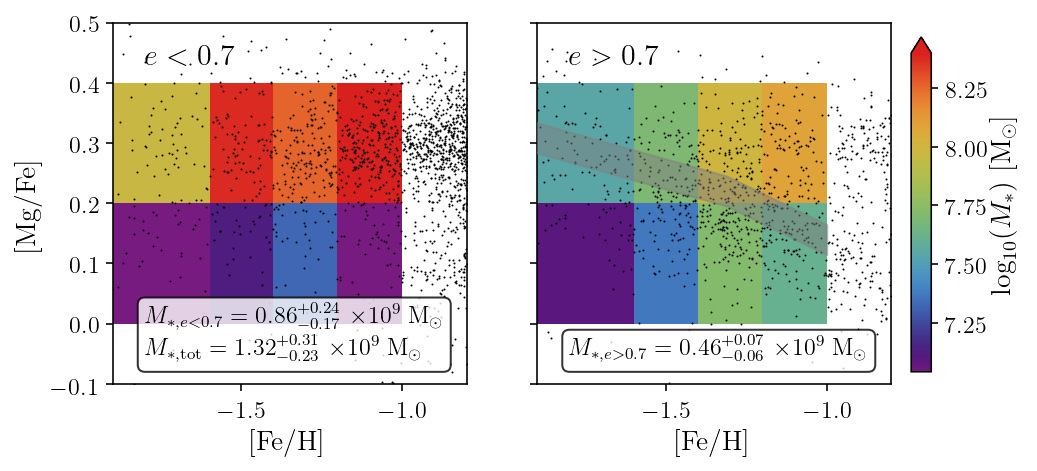

In [54]:
afebins = [0.,0.2,0.4]
ebins = [0.,0.7,1.]
fehbins = [-1.6,-1.4,-1.2,-1.]
lowafebins = [0.,0.4]
lowebins = [0.,0.7,1.]
lowfehbins = [-3,-1.6]

emasses_plot = np.copy(emasses)

ms = np.log10(np.nanmedian(emasses[:,:,:,:,0],axis=3))

vmin, vmax = np.nanmin(ms),np.nanmax(ms)

norm = matplotlib.colors.Normalize(
    vmin=vmin,
    vmax=vmax)

# choose a colormap
c_m = cm_rainbow

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])   


fig,ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(textwidth, columnwidth)
mask = mes < 0.7
ax[0].scatter(allstar_f[omask]['FE_H'][mask], allstar_f[omask]['MG_FE'][mask], s=1, lw=0., color='Black', rasterized=True)
ax[0].scatter(-9999,-9999,s=10,color='Black', label=r'APOGEE DR14')
ax[0].set_xlim(-1.9,-0.8)
ax[0].set_ylim(-0.1,0.5)

ylim = ax[0].get_ylim()
yscale = (ylim[1]-ylim[0])

ax[0].imshow(np.log10(np.rot90(np.median(emasses[:,:,:,:,0],axis=3))[:,:,0]), extent=[fehbins[0],fehbins[-1],afebins[0],afebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)
ax[0].imshow(np.log10(np.rot90(np.median(lowemasses[:,:,:,:,0],axis=3))[:,:,0]), extent=[lowfehbins[0],lowfehbins[-1],lowafebins[0],lowafebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)

mask = mes > 0.7
ax[1].scatter(allstar_f[omask]['FE_H'][mask], allstar_f[omask]['MG_FE'][mask], s=1, lw=0., color='Black', rasterized=True)
ax[1].scatter(-9999,-9999,s=10,color='Black', label=r'APOGEE DR14')
ax[1].set_xlim(-1.9,-0.8)
ax[1].set_ylim(-0.1,0.5)

ylim = ax[1].get_ylim()
yscale = (ylim[1]-ylim[0])

i = ax[1].imshow(np.log10(np.rot90(np.median(emasses[:,:,:,:,0],axis=3)[:,:,1])), extent=[fehbins[0],fehbins[-1],afebins[0],afebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)
ax[1].imshow(np.log10(np.rot90(np.median(lowemasses[:,:,:,:,0],axis=3))[:,:,1]), extent=[lowfehbins[0],lowfehbins[-1],lowafebins[0],lowafebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)

m1, m2, br, br_level = [-0.15, -0.26, -1.31,0.22]
def sausage(feh, par=[m1,m2, br, br_level]):
    m1,m2,br,br_level = par
    if isinstance(feh,float):
        feh = np.array([feh,])
    out = np.zeros(len(feh))
    c = br_level-m1*br
    c2 = br_level-m2*br
    out[feh < br] = m1*feh[feh < br] + c
    out[feh > br] = m2*feh[feh >br] + c2
    return out

xs = np.linspace(-2.,-1.,100)
ax[1].fill_between(xs, sausage(xs)+0.025, sausage(xs)-0.025, zorder=4, color='Grey', alpha=0.5)


plt.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92,0.15,0.02,0.7])


plt.colorbar(i, cax=cax, label=r'$\log_{10}(M_*)\ \mathrm{[M_\odot]}$', extend='max')


ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[0].set_ylabel(r'$\mathrm{[Mg/Fe]}$')



totmass = np.nanpercentile(np.nansum(np.nansum(np.nansum(emasses_plot[:,:,:,:,0], axis=0), axis=0),axis=0)+np.sum(np.sum(np.sum(lowemasses[:,:,:,:,0], axis=0), axis=0),axis=0), [16,50,84])/1e9
lo_err = totmass[1]-totmass[0]
hi_err = totmass[2]-totmass[1]


loe_totmass = np.percentile(np.nansum(np.nansum(emasses_plot[:,:,0,:,0], axis=0),axis=0)+ np.nansum(np.nansum(lowemasses[:,:,0,:,0], axis=0),axis=0), [16,50,84])/1e9#+ np.percentile(np.nansum(np.nansum(lowemasses[:,:,0,:,0], axis=0),axis=0), [16,50,84])/1e9
loe_lo_err = loe_totmass[1]-loe_totmass[0]
loe_hi_err = loe_totmass[2]-loe_totmass[1]

hie_totmass = np.percentile(np.nansum(np.nansum(emasses_plot[:,:,1,:,0], axis=0),axis=0)+np.nansum(np.nansum(lowemasses[:,:,1,:,0], axis=0),axis=0), [16,50,84])/1e9 #+ np.percentile(np.nansum(np.nansum(lowemasses[:,:,1,:,0], axis=0),axis=0), [16,50,84])/1e9
hie_lo_err = hie_totmass[1]-hie_totmass[0]
hie_hi_err = hie_totmass[2]-hie_totmass[1]

props = dict(boxstyle='round', alpha=0.8, facecolor='White', edgecolor='Black')
ax[0].text(-1.8,-0.06,r'$M_{*,e < 0.7} = '+str(round(loe_totmass[1],2))+'^{+'+str(round(loe_hi_err,2))+'}_{-'+str(round(loe_lo_err,2))+r'}\ \mathrm{\times 10^{9}\ M_{\odot}}$'+' \n'+r'$M_{*,\mathrm{tot}} = '+str(round(loe_totmass[1]+hie_totmass[1],2))+'^{+'+str(round(loe_hi_err+hie_hi_err,2))+'}_{-'+str(round(loe_lo_err+hie_lo_err,2))+r'}\ \mathrm{\times 10^{9}\ M_{\odot}}$',  fontsize=12., bbox=props)
ax[1].text(-1.8,-0.06,r'$M_{*,e > 0.7} = '+str(round(hie_totmass[1],2))+'^{+'+str(round(hie_hi_err,2))+'}_{-'+str(round(hie_lo_err,2))+r'}\ \mathrm{\times 10^{9}\ M_{\odot}}$',  fontsize=12., bbox=props)


ax[0].text(-1.8,0.43, r'$e < 0.7$', fontsize=15.)
ax[1].text(-1.8,0.43, r'$e > 0.7$', fontsize=15.)


plt.savefig('../plots/MAPS_mass_eccentricity_bins_spl_cutoff+disk_e0p7.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/MAPS_mass_eccentricity_bins_spl_cutoff+disk_e0p7.png', format='png', dpi=400, bbox_inches='tight')

#### Plotting the $\alpha$ of MAPs (Figure 5):

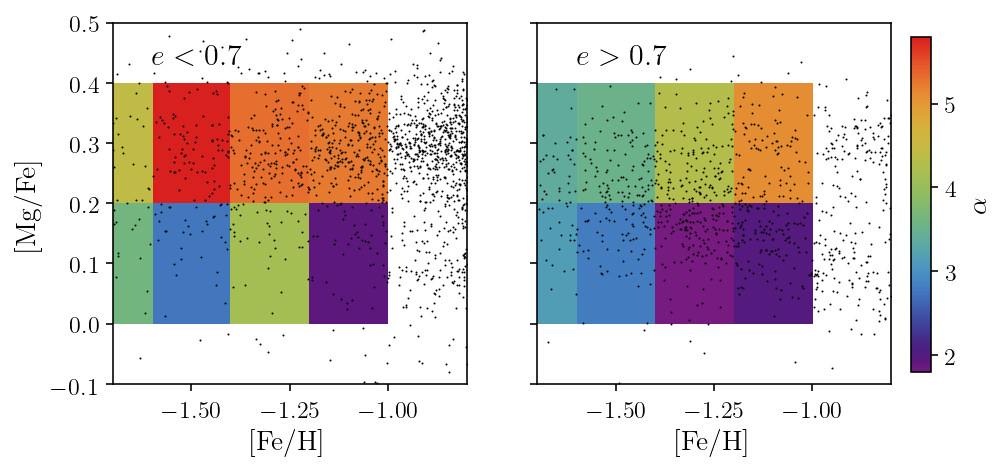

In [56]:
alphas = np.median(esamples, axis=3)[:,:,:,0]
lowalphas = np.median(lowesamples, axis=3)[:,:,:,0]
vmin, vmax = np.nanmin(alphas), np.nanmax(alphas)

norm = matplotlib.colors.Normalize(
    vmin=vmin,
    vmax=vmax)

# choose a colormap
c_m = cm_rainbow

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])   

fig,ax = plt.subplots(1,2, sharey=True)
fig.set_size_inches(textwidth, columnwidth)
mask = mes < 0.7
ax[0].scatter(allstar_f[omask]['FE_H'][mask], allstar_f[omask]['MG_FE'][mask], s=1, lw=0., color='Black', rasterized=True)
ax[0].scatter(-9999,-9999,s=10,color='Black', label=r'APOGEE DR14')
ax[0].set_xlim(-1.7,-0.8)
ax[0].set_ylim(-0.1,0.5)

ylim = ax[0].get_ylim()
yscale = (ylim[1]-ylim[0])

ax[0].imshow(np.rot90(alphas[:,:,0]), extent=[fehbins[0],fehbins[-1],afebins[0],afebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)
ax[0].imshow(np.rot90(lowalphas[:,:,0]), extent=[lowfehbins[0],lowfehbins[-1],lowafebins[0],lowafebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)

mask = mes > 0.7
ax[1].scatter(allstar_f[omask]['FE_H'][mask], allstar_f[omask]['MG_FE'][mask], s=1, lw=0., color='Black', rasterized=True)
ax[1].scatter(-9999,-9999,s=10,color='Black', label=r'APOGEE DR14')
ax[1].set_xlim(-1.7,-0.8)
ax[1].set_ylim(-0.1,0.5)

ylim = ax[1].get_ylim()
yscale = (ylim[1]-ylim[0])

i = ax[1].imshow(np.rot90(alphas[:,:,1]), extent=[fehbins[0],fehbins[-1],afebins[0],afebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)
ax[1].imshow(np.rot90(lowalphas[:,:,1]), extent=[lowfehbins[0],lowfehbins[-1],lowafebins[0],lowafebins[-1]], aspect='auto', cmap=c_m, vmin=vmin, vmax=vmax)

plt.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92,0.15,0.02,0.7])


plt.colorbar(i, cax=cax, label=r'$\alpha$')


ax[0].text(-1.6,0.43, r'$e < 0.7$', fontsize=15.)
ax[1].text(-1.6,0.43, r'$e > 0.7$', fontsize=15.)



ax[0].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[1].set_xlabel(r'$\mathrm{[Fe/H]}$')
ax[0].set_ylabel(r'$\mathrm{[Mg/Fe]}$')


plt.savefig('../plots/MAPS_exponents_eccentricity_bins_spl_cutoff+disk_e0p7.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/MAPS_exponents_eccentricity_bins_spl_cutoff+disk_e0p7.png', format='png', dpi=400, bbox_inches='tight')

#### Plot the shape parameters at high and low $e$ (Figure 6):

0.6185258691363928
0.8121326902692667
0.6706598205191905
0.6564947455683612


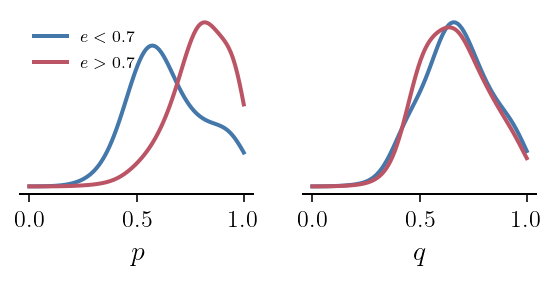

In [57]:
bins = np.linspace(0.,1.,100)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth/1.5,columnwidth/2)
kde = gaussian_kde(esamples[:,:,0,:,2].ravel(), bw_method=0.4)
ax[0].plot(bins,kde(bins), color='#4477AA', lw=2., label=r'$ e < 0.7$')
print(np.median(esamples[:,:,0,:,2].ravel()))
kde = gaussian_kde(esamples[:,:,1,:,2].ravel(), bw_method=0.4)
ax[0].plot(bins,kde(bins), color='#BB5566', lw=2., label=r'$ e > 0.7$')
print(np.median(esamples[:,:,1,:,2].ravel()))

kde = gaussian_kde(esamples[:,:,0,:,3].ravel(), bw_method=0.4)
ax[1].plot(bins,kde(bins), color='#4477AA', lw=2.)
print(np.median(esamples[:,:,0,:,3].ravel()))
kde = gaussian_kde(esamples[:,:,1,:,3].ravel(), bw_method=0.4)
ax[1].plot(bins,kde(bins), color='#BB5566', lw=2.)
print(np.median(esamples[:,:,1,:,3].ravel()))

ax[0].axes.get_yaxis().set_visible(False)
ax[0].set_frame_on(False)
xmin, xmax = ax[0].get_xaxis().get_view_interval()
ymin, ymax = ax[0].get_yaxis().get_view_interval()
ax[0].add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_frame_on(False)
xmin, xmax = ax[1].get_xaxis().get_view_interval()
ymin, ymax = ax[1].get_yaxis().get_view_interval()
ax[1].add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

ax[0].legend(frameon=False, fontsize='small')
ax[0].set_xlabel(r'$p$')
ax[1].set_xlabel(r'$q$')
ax[0].set_xticks([0.,0.5,1.])
ax[1].set_xticks([0.,0.5,1.])

plt.savefig('../plots/triaxiality_spl_cutoff+disk_e0p7.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.savefig('../plots/triaxiality_spl_cutoff+disk_e0p7.png', format='png', dpi=400, bbox_inches='tight')